# Protein Interaction Network Clustering
## Introduction
It is possible to detect community structures within these networks, and this can be applied to predict functions of proteins and to identify protein complexes. Various methods have been proposed and the project will compare existing methods and explore new approaches, applying Bayesian methods to determine clusters and including prior information where applicable. Hierarchical approaches will be considered as well as methods that can include covariates such as gene expression levels.

Software to perform clustering of protein interaction networks has been developed in the python implementation language and applied to protein interaction network data, and the clustering produced will be compared to other existing methodologies. It was necessary to implement existing methods from the literature for comparison purposes, since software was not be publicly available. 

Additionally a side goal of representing protein interaction networks graphically has been set, and explored using a variety of packages and own programming.

# Defining the Set Up
## A simple example
Below a simple program has been made to parse a protein interaction database of the **Saccharomyces cerevisae** yeast species of approx. 6000 protein interactions. Here however only a small subset of the interactions has been taken, and represents 160 protein interactions for purposes discussed below

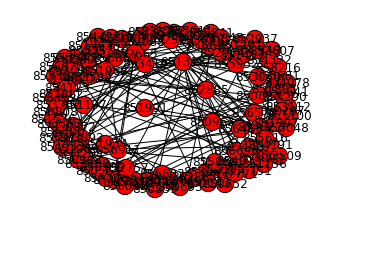

In [2]:
# %load source/simpleGraph.py
%matplotlib inline
"""
This module reads in a tab delimited txt file with the first two columns and
makes a dictionary with first column and second column
"""

import csv
import networkx as nx
import matplotlib.pyplot as plt

data_file = open('scOrgSmall.tab2.txt','r')
reader = csv.reader(data_file, delimiter = "\t")
table = list(reader)

##################################################################
############        Data Structure Creation           ############
##################################################################
# A {protein, [interactingProtein]} dictionary
# create dictionary of proteins and the proteins they were shown
# to have interactions with.
ppi_dict = {}
for row in table[1:]:
	prot_a = row[1]
	prot_b = row[2]
	if prot_a in ppi_dict:
		if prot_b in ppi_dict[prot_a]:
			pass
		else:
			ppi_dict[prot_a].append(prot_b)
	else:
		ppi_dict[prot_a] = [prot_b]

# Create a graph through adding the edges.
ppi_graph = nx.Graph()
protein_a_list = ppi_dict.keys()
for protein_a in protein_a_list:
	for protein_b in ppi_dict[protein_a]:
		ppi_graph.add_edge(protein_a, protein_b)

# Draw the graph onto canvas
pos = nx.spring_layout(ppi_graph,k=0.9,iterations=20, scale=5)
nx.draw_networkx_nodes(ppi_graph, pos=pos, nodelist = ppi_graph.nodes())
nx.draw_networkx_edges(ppi_graph, pos=pos, edgelist = ppi_graph.edges())
nx.draw_networkx_labels(ppi_graph, pos=pos)

# Display the canvas
plt.axis('off')
plt.show()


This created a simple graph with nodes representing protein id's and edges denoting an interaction between two proteins. The graph is undirected and hard to make information out of and therefore several clustering techniques are employed to create weightings, and positionings of the graph nodes, to make different looking graphs. In addition to making graphs look different via different clustering techniques benchmarks are made to see the "performance" of clustering techniques. 

### Getting some information out of the graph
Here we just look at getting some useful information out of the graph above to make further analysis

In [14]:
# find the nodes
nodes = ppi_graph.nodes()
# find the number of nodes
num_nodes = ppi_graph.number_of_nodes()
# finding the neighbours of a as a list
nei_a = ppi_graph.neighbors("851136")
# look at connected items
whatsConn = nx.connected_components(ppi_graph)
# look at degree of each node
nodeDegs_dict = nx.degree(ppi_graph)
# compute the clustering coefficient for each node
nx.clustering(ppi_graph)

print nodes[0]



853030


# Clustering

While there seems to be some kind of structure hinting at clusters (in the middle of the graph) this is illuisonary as no clustering algorithm has been performed on the data and the positioning of the nodes in the graph. The positionin of the graph was simply done by the `nx.spring_layout()` function of nx. 

## Simple Clustering Algorithm

This sections introduces a simple clustering algorithm which places each node in two clusters based on whether it interacts with a given protein or not. 

## (New Clustering Method) Fixed Number of Clusters


In [17]:
# %load source/simpleNetworkCluster.py
#!/usr/bin/python
"""
This module implements a simplified network clustering technique designed by 
Dr. Tom Thorne of The University of Edinburgh.

As little information is available about the protein interactions from the
database 
"""

import csv
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from operator import mul
from source.netCalc import calculateClassLikelihood, calculate_prob_weight, number_edgesKToL

##################################################################
############              File Reading                ############
##################################################################

data_file = open('scOrgSmall.tab2.txt','r')
reader = csv.reader(data_file, delimiter = "\t")
table = list(reader)

##################################################################
############        Data Structure Creation           ############
##################################################################
# A {protein, [interactingProtein]} dictionary
# create dictionary of proteins and the proteins they were shown
# to have interactions with.
ppi_dict = {}
for row in table[1:]:
	prot_a = row[1]
	prot_b = row[2]
	if prot_a in ppi_dict:
		if prot_b in ppi_dict[prot_a]:
			pass
		else:
			ppi_dict[prot_a].append(prot_b)
	else:
		ppi_dict[prot_a] = [prot_b]

# Create a graph through adding the edges.
ppi_graph = nx.Graph()
protein_a_list = ppi_dict.keys()
for protein_a in protein_a_list:
	for protein_b in ppi_dict[protein_a]:
		ppi_graph.add_edge(protein_a, protein_b)


##################################################################
############         Clustering Algorithm             ############
##################################################################

# for a network A of n proteins we fix the number of clusters to k
num_clusters = 8

# A dictionary linking protein with the cluster it is assigned to
# for now a random assignment.
pClasses = {}
for row in table[1:]:
	prot_a = row[1]
	pClasses[prot_a] = random.choice(range(num_clusters))

# A k by k symmetric matrix of weights (the probability of a protein in
# in one cluster interacting with a protein in another)
weight_matrix = np.zeros((num_clusters,num_clusters))

# Setting the weights of the weight_matrix via sampling from a beta distribution
alpha = 2 
beta = 8
for k in range(num_clusters):
	for l in range(num_clusters):
		starterValue = np.random.beta(alpha, beta)
		weight_matrix[k,l] = starterValue
		weight_matrix[l,k] = starterValue

# for some set number of iterations
for iteration in xrange(10000):
	for prot_a in range(ppi_graph.nodes()):
		r = []
		for classId in range(num_clusters):
			likelihood_ik = calculateClassLikelihood(prot_a, classId, ppi_graph, pClasses, weight_matrix) 
			r.append(likelihood_ik)
		# normalise r
		norm_r = [float(j)/sum(r) for j in r]
		# sample zi as a random integer in range 1 to num_clusters with weights r
		# TODO (but how?)

		# calculate mk, the numnber of zi = k for k in 1..K
		list_mk = []
		for x in range(num_clusters):
			list_mk.append(pClasses.values().count(pClasses[x]))

		# calculate nk,l the number of interactions (i,j) where zi = k, and zj = l
		# for k,l in 1..num_clusters
		numkl = {}
		for k in range(num_clusters):
			for l in range(num_clusters):
				numkl[(k, l)] = number_edgesKToL(k,l,pClasses, ppi_graph) 

		for k in range(num_clusters):
			for l in range(num_clusters):
				newValue = np.random.beta(alpha + numkl[(k,l)], beta + (list_mk[k]*list_mk[l]-numkl[(k,l)]))
				weight_matrix[k,l] = newValue
				weight_matrix[l,k] = newValue









ImportError: No module named source.netCalc